## Two Moons Normalizing Flow Using Distrax + Haiku
Here is an implementation of the Neural Spline Flow (`NSF`) based off of `distrax` [documentation](https://github.com/deepmind/distrax/blob/master/examples/flow.py) for a flow. For a more detailed walkthrough of the math behind normalizing flow, see this [notebook's](https://colab.research.google.com/github/nsanghi/probml-notebooks/blob/add_mnist_spline_flow_jax/notebooks/flow_spline_mnist_jax.ipynb#scrollTo=l0K_D4QX74gV) example using MNIST. Code to load 2 moons example dataset sourced from Chris Waites's jax-flows [demo](https://github.com/ChrisWaites/jax-flows/blob/master/examples/intro.ipynb).

In [18]:
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn import datasets, preprocessing
import jax
import jax.numpy as jnp
import numpy as np

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify
try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds
try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax
try:
    import haiku as hk
except ModuleNotFoundError:
    %pip install -qq -U dm-haiku
    import haiku as hk
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


# Plotting 2 moons dataset
Code taken directly from Chris Waites's jax-flows [demo](https://github.com/ChrisWaites/jax-flows/blob/master/examples/intro.ipynb). This is the distribution we want to create a bijection to from a simple base distribution, such as a gaussian distribution.

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


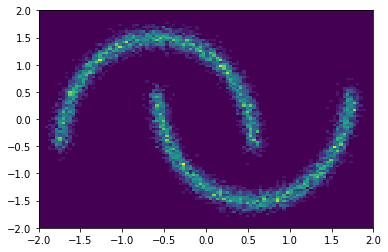

In [19]:
latexify(width_scale_factor=1, fig_height=1.5)
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = scaler.fit_transform(X)
plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1]

## Creating the normalizing flow in distrax+haiku
Instead of a uniform distribution, we use a Gaussian distribution as the base distribution. This makes more sense for a standardized two moons dataset that is scaled according to a normal distribution using `sklearn`'s `StandardScaler()`. Using a uniform base distribution will result in `inf` and `nan` loss.

In [20]:
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple

# Hyperparams - change these to experiment
flow_num_layers = 8 
mlp_num_layers = 4 
hidden_size = 1000 
num_bins = 8 
batch_size = 512
learning_rate = 1e-4
eval_frequency = 100

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


# Functions to create a distrax normalizing flow
def make_conditioner(event_shape: Sequence[int],
                     hidden_sizes: Sequence[int],
                     num_bijector_params: int) -> hk.Sequential:
  """Creates an MLP conditioner for each layer of the flow."""
  return hk.Sequential([
      hk.Flatten(preserve_dims=-len(event_shape)),
      hk.nets.MLP(hidden_sizes, activate_final=True),
      # We initialize this linear layer to zero so that the flow is initialized
      # to the identity function.
      hk.Linear(
          np.prod(event_shape) * num_bijector_params,
          w_init=jnp.zeros,
          b_init=jnp.zeros),
      hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
  ])


def make_flow_model(event_shape: Sequence[int],
                    num_layers: int,
                    hidden_sizes: Sequence[int],
                    num_bins: int) -> distrax.Transformed:
  """Creates the flow model."""
  # Alternating binary mask.
  mask = jnp.arange(0, np.prod(event_shape)) % 2
  mask = jnp.reshape(mask, event_shape)
  mask = mask.astype(bool)

  def bijector_fn(params: Array):
    return distrax.RationalQuadraticSpline(
        params, range_min=-2., range_max=2.)

  # Number of parameters for the rational-quadratic spline:
  # - `num_bins` bin widths
  # - `num_bins` bin heights
  # - `num_bins + 1` knot slopes
  # for a total of `3 * num_bins + 1` parameters.
  num_bijector_params = 3 * num_bins + 1

  layers = []
  for _ in range(num_layers):
    layer = distrax.MaskedCoupling(
        mask=mask,
        bijector=bijector_fn,
        conditioner=make_conditioner(event_shape, hidden_sizes,
                                     num_bijector_params))
    layers.append(layer)
    # Flip the mask after each layer.
    mask = jnp.logical_not(mask)

  # We invert the flow so that the `forward` method is called with `log_prob`.
  flow = distrax.Inverse(distrax.Chain(layers))

  # Making base distribution normal distribution
  mu = jnp.zeros(event_shape) 
  sigma = jnp.ones(event_shape) 
  base_distribution = distrax.Independent(
      distrax.MultivariateNormalDiag(mu, sigma))
  return distrax.Transformed(base_distribution, flow)


def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
  # ds = tfds.load("mnist", split=split, shuffle_files=True)
  ds = split
  ds = ds.shuffle(buffer_size=10 * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=1000)
  ds = ds.repeat()
  return iter(tfds.as_numpy(ds))


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
  data = batch.astype(np.float32)
  return data


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int) -> Array:
  model = make_flow_model(
      event_shape=TWO_MOONS_SHAPE,
      num_layers=flow_num_layers,
      hidden_sizes=[hidden_size] * mlp_num_layers,
      num_bins=num_bins)
  return model.sample(seed=key, sample_shape=[num_samples])


@hk.without_apply_rng
@hk.transform
def log_prob(data: Array) -> Array:
  model = make_flow_model(
      event_shape=TWO_MOONS_SHAPE,
      num_layers=flow_num_layers,
      hidden_sizes=[hidden_size] * mlp_num_layers,
      num_bins=num_bins)
  return model.log_prob(data)


def loss_fn(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:
  data = prepare_data(batch, prng_key)
  # Loss is average negative log likelihood.
  loss = -jnp.mean(log_prob.apply(params, data))
  return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
  data = prepare_data(batch)  # We don't dequantize during evaluation.
  loss = -jnp.mean(log_prob.apply(params, data))
  return loss


## Setting up the optimizer

In [21]:
optimizer = optax.adam(learning_rate)


@jax.jit
def update(params: hk.Params,
            prng_key: PRNGKey,
            opt_state: OptState,
            batch: Batch) -> Tuple[hk.Params, OptState]:
  """Single SGD update step."""
  grads = jax.grad(loss_fn)(params, prng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

## Training the flow


In [30]:
# Event shape - only two dimensions
TWO_MOONS_SHAPE = (2,)

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Initializing PRNG and Neural Net params
prng_seq = hk.PRNGSequence(1)
params = log_prob.init(next(prng_seq), np.zeros((1, *TWO_MOONS_SHAPE)))
opt_state = optimizer.init(params)

training_steps = 4000

for step in range(training_steps):
  params, opt_state = update(params, next(prng_seq), opt_state,
                              next(train_ds))

  if step % eval_frequency == 0:
    val_loss = eval_fn(params, next(valid_ds))
    print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")


STEP:     0; Validation loss: 2.775
STEP:   100; Validation loss: 1.597
STEP:   200; Validation loss: 1.398
STEP:   300; Validation loss: 1.335
STEP:   400; Validation loss: 1.326
STEP:   500; Validation loss: 1.319
STEP:   600; Validation loss: 1.362
STEP:   700; Validation loss: 1.284
STEP:   800; Validation loss: 1.270
STEP:   900; Validation loss: 1.295
STEP:  1000; Validation loss: 1.294
STEP:  1100; Validation loss: 1.306
STEP:  1200; Validation loss: 1.305
STEP:  1300; Validation loss: 1.278
STEP:  1400; Validation loss: 1.239
STEP:  1500; Validation loss: 1.340
STEP:  1600; Validation loss: 1.289
STEP:  1700; Validation loss: 1.283
STEP:  1800; Validation loss: 1.296
STEP:  1900; Validation loss: 1.279
STEP:  2000; Validation loss: 1.231
STEP:  2100; Validation loss: 1.344
STEP:  2200; Validation loss: 1.331
STEP:  2300; Validation loss: 1.249
STEP:  2400; Validation loss: 1.262
STEP:  2500; Validation loss: 1.264
STEP:  2600; Validation loss: 1.359
STEP:  2700; Validation loss

We can now look at the trained flow's output. It should be the same, or close, to the original Two Moons dataset that we are trying to model.

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


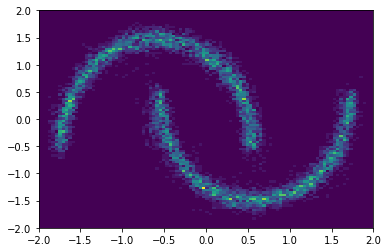

In [31]:
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

X_transf = model_sample.apply(params, next(prng_seq), num_samples=n_samples)
plt.hist2d(X_transf[:, 0], X_transf[:, 1], bins=n_bins, range=plot_range)[-1]

plt.savefig("two-moons-nsf-flow.pdf")
plt.savefig("two-moons-nsf-flow.png")
plt.show()

To sample intermediate layers, need to get `haiku` parameters and match those to intermediate layers of the NSF. This isn't trivial but we can use the names of the modules to group them and then use those to sample from the base gaussian. To get the parameters, we need to parse the keys that `haiku` uses to store parameter values from each module. For the `NSF` flow, each layer is composed of an affine transformation and series of `MLPs` to condition the masked coupling layer. To parse, we'll use some regex to determine the key name and use that to find the indices of the ordered dictionary of each layer. We'll collect each layer in a list within a larger list of all the lists.

Maybe we could have used better naming convention, but we leave that as an exercise for the reader.

In [32]:
import re

params_list = params.keys()
layer_indices = []

for i in range(flow_num_layers):

  p = re.compile(f'.*{i}/.|^linear_{i}$')  
  start_p = re.compile(f'^mlp/.|^linear$')

  # re.findall([key for key in params.keys()], p)
  # print([i for i, string in enumerate(params_list) if re.findall(p, string) != []])
  if i == 0: 
    layer_indices.append([i for i, string in enumerate(params_list) if re.findall(start_p, string) != []])
    continue
  layer_indices.append([i for i, string in enumerate(params_list) if re.findall(p, string) != []])

params_list = [key for key in params_list]

outer_list = []

for i in layer_indices:
  inner_list = []
  for j in i:
    inner_list.append(params_list[j])
  outer_list.append(inner_list)

We now can use a `haiku` data structure (`filter`) to get the params according to the list of the module neames we've collected. Thus, we have a list of the layers' parameters.

To sample sequential layers, we need the cumulative parameters up to that layer. Those will be the parameters that we'll use in our asmple function, whose skeleton is made for the number of layers we seek to sample.

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


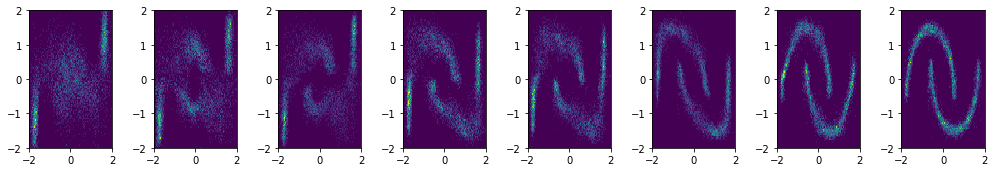

In [33]:
fig, axes = plt.subplots(ncols=flow_num_layers, figsize=(14,2.5))
fig.tight_layout()

# Loop it.
for i in range(1, flow_num_layers+1):
  @hk.without_apply_rng
  @hk.transform
  def model_sample(key: PRNGKey, num_samples: int) -> Array:
    model = make_flow_model(
        event_shape=TWO_MOONS_SHAPE,
        num_layers=i, # Only thing that changes here....
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins)
    return model.sample(seed=key, sample_shape=[num_samples])

  # Accumulate the parameters you want to use
  keys = sum(outer_list[:i], [])

  # Get new dictionary based on the new keys
  temp_params = dict(filter(lambda x:x[0] in keys, params.items()))

  # Sample and plot
  X_transf = model_sample.apply(temp_params, next(prng_seq), num_samples=n_samples)
  axes[i-1].hist2d(X_transf[:, 0], X_transf[:, 1], bins=n_bins, range=plot_range)[-1]

# Building a Continuous Normalizing Flow (CNF)
Continuing from section 22.2.6 of the book. A continuous normalizing flow is the continuous-time expansion of normalizing flows in the limit as the number of layers of affine transformations approaches infinity. We can model this continuous setting as: 

$$
\frac{d \boldsymbol{x}}{dt} = \boldsymbol{F}( \boldsymbol{x} (t), t),
$$

where $\boldsymbol{F} : \mathbb{R}^D \times [0,T] → \mathbb{R}^D$ is a time dependent vector field that parameterizes the ODE. In this setting, our flow from base $p(u)$ to $p(x)$ is the integration of the differential equation from $t=0$ to $t=1$ of the defined differential equation. Note, that we can define the differential equation on the right-hand side of the equation by any arbitrary neural network that may have $k$ layers, as we'll see in a moment. 

We need to define the flow of a data point, $x$, from a base distribution to the data distribution. The defined differential equation can be thought of as the velocity of particle $x(t)$ at some time point $t$. Thus, numerically integrating by Euler's method or another more advanced technique will result in the path from the base to data distribution. We define this change as:

$$
\frac{d L}{dt} (t) = \text{tr}[ \boldsymbol{J} ( \boldsymbol{F}( \cdot , (t))( x(t))],
$$

where $L(t)$ s the Jacobian determinant of $\boldsymbol{f}$ that we would like to define. So, we need to keep track of both the particle $x$ position at each time point, as well as the Jacobian determinant. It's important to note that the right-hand side is the divergence of $\boldsymbol{f}$. The divergence is usually difficult to calculate but the Hutchinson Trace estimator can be used to approximate the Jacobian trace of $\boldsymbol{F}(\cdot, t)$.

What's interesting to note is that the right-hand side of the equation is a composition of arbitrary neural networks linked together that do not need to satisfy the invertibility constraint of affine normalizing flows due to the Piccard Existence Theorem. Briefly, if the functions are uniformly Lipschitz continuous and continuous in $t$, then the ODE has a unique solution. Many neural networks have this property and allow one to skip the invertibility requirement and tractability of the Jacobian determinant. 

More explicitly, the function $\boldsymbol{F}$ can be composed of $k$ neural networks, $\boldsymbol{f}$. Plugging this into the differential equation, this looks like:

$$
\boldsymbol{x} = \boldsymbol{u} + \int_0^T \sum_{k}^D \frac{\partial f_{\theta, k}}{\partial x_k} (t, x(t, x_i)) dt .
$$

So, for each timestep, all $k$ functional layers, $\boldsymbol{f}_{\theta}$, need to be evaluated. We solve by going backwards from $\boldsymbol{u} → \boldsymbol{x}$, which is simply

$$
\boldsymbol{u} = \boldsymbol{x} + \int_T^0 \sum_{k}^D \frac{\partial f_{\theta, k}}{\partial x_k} (t, x(t, x_i)) dt = \boldsymbol{x} - \int_0^T \sum_{k}^D \frac{\partial f_{\theta, k}}{\partial x_k} (t, x(t, x_i)) dt .
$$

This formulation allows evaluation to proceed by either forward or backward evalution of the data point in time. Note that backpropagation will have to be evaluated in the reverse direction, which will require the ODE solver to be able to go backwards in time, regardless of integration limits chosen here! 

## Implementing the CNF
Theory reviewed, we can implement the CNF. We will work off of (directly copy, mostly) Patrick Kidger's example code for his `diffrax` library for differential equation solvers, found [here](https://docs.kidger.site/diffrax/examples/continuous_normalising_flow/). As of July 2022, this is the most comprehensive Jax library for differential equation solvers. We will also work with the `equinox` neural network library instead of `haiku`, as the `equinox` library allows for more easily reversing neural network modules than `haiku`. Even though `haiku` or `flax` could be used if their layers can be reversed, that requires a little more work than just using `equinox` in this case. 

We also use the `diffrax` library as it enables us to plug into other differential equations that can be used with probabilistic models, such as stochastic differential equations that can be used with diffusion models. 




In [34]:
import math
import pathlib
import time
from typing import List, Tuple

try:
    import diffrax
except ModuleNotFoundError:
    %pip install -qq diffrax
    import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import imageio
import jax.lax as lax
import jax.nn as jnn
import jax.random as jrandom
import scipy.stats as stats


here = pathlib.Path(os.getcwd())

# Loading up the two moons dataset
n_samples = 10000

scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = scaler.fit_transform(X)

input_dim = X.shape[1]


class Func(eqx.Module):
    layers: List[eqx.nn.Linear]

    def __init__(self, *, data_size, width_size, depth, key, **kwargs):
        super().__init__(**kwargs)
        keys = jrandom.split(key, depth + 1)
        layers = []
        if depth == 0:
            layers.append(
                ConcatSquash(in_size=data_size, out_size=data_size, key=keys[0])
            )
        else:
            layers.append(
                ConcatSquash(in_size=data_size, out_size=width_size, key=keys[0])
            )
            for i in range(depth - 1):
                layers.append(
                    ConcatSquash(
                        in_size=width_size, out_size=width_size, key=keys[i + 1]
                    )
                )
            layers.append(
                ConcatSquash(in_size=width_size, out_size=data_size, key=keys[-1])
            )
        self.layers = layers

    def __call__(self, t, y, args):
        t = jnp.asarray(t)[None]
        for layer in self.layers[:-1]:
            y = layer(t, y)
            y = jnn.tanh(y)
        y = self.layers[-1](t, y)
        return y


# Credit: this layer, and some of the default hyperparameters below, are taken from the
# FFJORD repo.
class ConcatSquash(eqx.Module):
    lin1: eqx.nn.Linear
    lin2: eqx.nn.Linear
    lin3: eqx.nn.Linear

    def __init__(self, *, in_size, out_size, key, **kwargs):
        super().__init__(**kwargs)
        key1, key2, key3 = jrandom.split(key, 3)
        self.lin1 = eqx.nn.Linear(in_size, out_size, key=key1)
        self.lin2 = eqx.nn.Linear(1, out_size, key=key2)
        self.lin3 = eqx.nn.Linear(1, out_size, use_bias=False, key=key3)

    def __call__(self, t, y):
        return self.lin1(y) * jnn.sigmoid(self.lin2(t)) + self.lin3(t)


def approx_logp_wrapper(t, y, args):
    y, _ = y
    *args, eps, func = args
    fn = lambda y: func(t, y, args)
    f, vjp_fn = jax.vjp(fn, y)
    (eps_dfdy,) = vjp_fn(eps)
    logp = jnp.sum(eps_dfdy * eps)
    return f, logp


def exact_logp_wrapper(t, y, args):
    y, _ = y
    *args, _, func = args
    fn = lambda y: func(t, y, args)
    f, vjp_fn = jax.vjp(fn, y)
    (size,) = y.shape  # this implementation only works for 1D input
    eye = jnp.eye(size)
    (dfdy,) = jax.vmap(vjp_fn)(eye)
    logp = jnp.trace(dfdy)
    return f, logp


def normal_log_likelihood(y):
    return -0.5 * (y.size * math.log(2 * math.pi) + jnp.sum(y**2))


class CNF(eqx.Module):
    funcs: List[Func]
    data_size: int
    exact_logp: bool
    t0: float
    t1: float
    dt0: float

    def __init__(
        self,
        *,
        data_size,
        exact_logp,
        num_blocks,
        width_size,
        depth,
        key,
        **kwargs,
    ):
        super().__init__(**kwargs)
        keys = jrandom.split(key, num_blocks)
        self.funcs = [
            Func(
                data_size=data_size,
                width_size=width_size,
                depth=depth,
                key=k,
            )
            for k in keys
        ]
        self.data_size = data_size
        self.exact_logp = exact_logp
        self.t0 = 0.0
        self.t1 = 0.5
        self.dt0 = 0.05

    # Runs backward-in-time to train the CNF.
    def train(self, y, *, key):
        if self.exact_logp:
            term = diffrax.ODETerm(exact_logp_wrapper)
        else:
            term = diffrax.ODETerm(approx_logp_wrapper)
        solver = diffrax.Tsit5()
        eps = jrandom.normal(key, y.shape)
        delta_log_likelihood = 0.0
        for func in reversed(self.funcs):
            y = (y, delta_log_likelihood)
            sol = diffrax.diffeqsolve(
                term, solver, self.t1, self.t0, -self.dt0, y, (eps, func)
            )
            (y,), (delta_log_likelihood,) = sol.ys
        return delta_log_likelihood + normal_log_likelihood(y)

    # To make illustrations, we have a variant sample method we can query to see the
    # evolution of the samples during the forward solve.
    def sample_flow(self, *, key):
        t_so_far = self.t0
        t_end = self.t0 + (self.t1 - self.t0) * len(self.funcs)
        save_times = jnp.linspace(self.t0, t_end, 9)
        y = jrandom.normal(key, (self.data_size,))
        out = []
        for i, func in enumerate(self.funcs):
            if i == len(self.funcs) - 1:
                save_ts = save_times[t_so_far <= save_times] - t_so_far
            else:
                save_ts = (
                    save_times[
                        (t_so_far <= save_times)
                        & (save_times < t_so_far + self.t1 - self.t0)
                    ]
                    - t_so_far
                )
                t_so_far = t_so_far + self.t1 - self.t0
            term = diffrax.ODETerm(func)
            solver = diffrax.Tsit5()
            saveat = diffrax.SaveAt(ts=save_ts)
            sol = diffrax.diffeqsolve(
                term, solver, self.t0, self.t1, self.dt0, y, saveat=saveat
            )
            out.append(sol.ys)
            y = sol.ys[-1]
        out = jnp.concatenate(out)
        assert len(out) == 9  # number of points we saved at
        return out


from functools import partial


class DataLoader(eqx.Module):
    arrays: Tuple[jnp.ndarray]
    batch_size: int
    key: jrandom.PRNGKey

    def __post_init__(self):
        dataset_size = self.arrays[0].shape[0]
        assert all(array.shape[0] == dataset_size for array in self.arrays)

    # @partial(jax.jit, static_argnums=1)
    def __call__(self, step):
        # dataset_size = self.arrays[0].shape[0]
        dataset_size = self.arrays.shape[0]
        num_batches = dataset_size // self.batch_size
        epoch = step // num_batches
        key = jrandom.fold_in(self.key, epoch)
        perm = jrandom.permutation(key, jnp.arange(dataset_size))
        start = step * self.batch_size
        slice_size = self.batch_size
        batch_indices = lax.dynamic_slice_in_dim(perm, start, slice_size)
        # return tuple(array[batch_indices] for array in self.arrays)
        return self.arrays[batch_indices]


def main(
    in_path,
    out_path=None,
    batch_size=500,
    virtual_batches=2,
    lr=1e-3,
    weight_decay=1e-5,
    steps=4000,  # Change this
    exact_logp=True,
    num_blocks=2,
    width_size=64,
    depth=3,
    print_every=10,
    seed=5678,
):
    if out_path is None:
        out_path = here / pathlib.Path(in_path).name
    else:
        out_path = pathlib.Path(out_path)

    key = jrandom.PRNGKey(seed)
    model_key, loader_key, loss_key, sample_key = jrandom.split(key, 4)

    dataset_size, data_size = X.shape
    dataloader = DataLoader(jnp.asarray(X), batch_size, key=loader_key)

    model = CNF(
        data_size=data_size,
        exact_logp=exact_logp,
        num_blocks=num_blocks,
        width_size=width_size,
        depth=depth,
        key=model_key,
    )

    optim = optax.adamw(lr, weight_decay=weight_decay)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    @eqx.filter_value_and_grad
    def loss(model, data, loss_key):
        batch_size, _ = data.shape
        noise_key, train_key = jrandom.split(loss_key, 2)
        train_key = jrandom.split(key, batch_size)
        log_likelihood = jax.vmap(model.train)(data, key=train_key)
        return -jnp.mean(log_likelihood)  # minimise negative log-likelihood

    @eqx.filter_jit
    def make_step(model, opt_state, step, loss_key):
        # We only need gradients with respect to floating point JAX arrays, not any
        # other part of our model. (e.g. the `exact_logp` flag. What would it even mean
        # to differentiate that? Note that `eqx.filter_value_and_grad` does the same
        # filtering by `eqx.is_inexact_array` by default.)
        value = 0
        grads = jax.tree_map(
            lambda leaf: jnp.zeros_like(leaf) if eqx.is_inexact_array(leaf) else None,
            model,
        )

        # Get more accurate gradients by accumulating gradients over multiple batches.
        # (Or equivalently, get lower memory requirements by splitting up a batch over
        # multiple steps.)
        def make_virtual_step(_, state):
            value, grads, step, loss_key = state
            data = dataloader(step)
            value_, grads_ = loss(model, data, loss_key)
            value = value + value_
            grads = jax.tree_map(lambda a, b: a + b, grads, grads_)
            step = step + 1
            loss_key = jrandom.split(loss_key, 1)[0]
            return value, grads, step, loss_key

        value, grads, step, loss_key = lax.fori_loop(
            0, virtual_batches, make_virtual_step, (value, grads, step, loss_key)
        )
        value = value / virtual_batches
        grads = jax.tree_map(lambda a: a / virtual_batches, grads)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state, step, loss_key

    step = 0
    while step < steps:
        start = time.time()
        value, model, opt_state, step, loss_key = make_step(
            model, opt_state, step, loss_key
        )
        end = time.time()
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {value}, Computation time: {end - start}")

    num_samples = 5000
    sample_key = jrandom.split(sample_key, num_samples)
    sample_flows = jax.vmap(model.sample_flow, out_axes=-1)(key=sample_key)
    return sample_flows

sample_flows = main(in_path=".")

flow_list = [flow for flow in sample_flows]

Step: 10, Loss: 2.840371608734131, Computation time: 0.652367115020752
Step: 20, Loss: 2.8196043968200684, Computation time: 0.6545634269714355
Step: 30, Loss: 2.8243536949157715, Computation time: 0.6536941528320312
Step: 40, Loss: 2.799053430557251, Computation time: 0.6585874557495117
Step: 50, Loss: 2.782413959503174, Computation time: 0.6526434421539307
Step: 60, Loss: 2.7622931003570557, Computation time: 0.6626815795898438
Step: 70, Loss: 2.732093095779419, Computation time: 0.6542849540710449
Step: 80, Loss: 2.7236363887786865, Computation time: 0.66660475730896
Step: 90, Loss: 2.6718854904174805, Computation time: 0.6599960327148438
Step: 100, Loss: 2.6688730716705322, Computation time: 0.6548497676849365
Step: 110, Loss: 2.7334365844726562, Computation time: 0.6545288562774658
Step: 120, Loss: 2.7228939533233643, Computation time: 0.6588914394378662
Step: 130, Loss: 2.6603989601135254, Computation time: 0.6552820205688477
Step: 140, Loss: 2.645991563796997, Computation time: 

## Comparing the NSF to the CNF
We've trained both models, now we can compare how they sample from a base Gaussian distribution to the data distribution. To do this, we sample once from each layer of the `NSF` to get a cumulative change due to the flow, with the last layer converting to the data distribution. 

Sampling the `CNF` is a little different. Since the `CNF` is modeled by a vector field changing from an initial timepoint to a final timepoint, we sample by evaluating the vector field at intermediate timesteps between the beginning and end time points. 

Comparing the two plots, you shouldd be able to see the difference between how each normalizing flow models the diffeomorphism from base to data distribution. The `NSF` makes more "jagged" steps, reminiscent of a taffy machine, while the `CNF` makes more smooth steps given the Lipschitz constraints of the neural networks that model its vector field. 

Note, however, that transitions of the `CNF` are limited by the expressiveness of the neural network used to describe the differential equation's vector field. This [paper](https://arxiv.org/abs/1904.01681) by Dupont et al. (2019) demonstrates how to overcome a shortcoming of Neural ODEs. 

Text(92.75, 0.5, 'CNF')

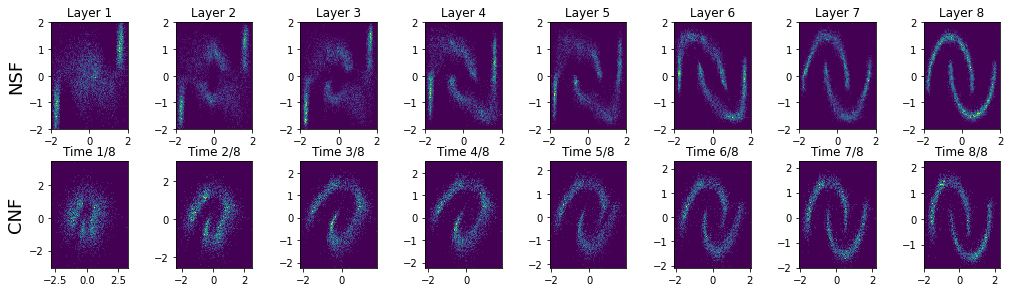

In [42]:
fig, axes = plt.subplots(2, flow_num_layers, figsize=(14,4))
fig.tight_layout()

# NSF
i = 0
for j in range(1, flow_num_layers+1):
  @hk.without_apply_rng
  @hk.transform
  def model_sample(key: PRNGKey, num_samples: int) -> Array:
    model = make_flow_model(
        event_shape=TWO_MOONS_SHAPE,
        num_layers=j, # Only thing that changes here....
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )
    return model.sample(seed=key, sample_shape=[num_samples])

  # Accumulate the parameters' keys you want to use
  keys = sum(outer_list[:j], [])

  # Get new dictionary based on the new keys
  temp_params = dict(filter(lambda x:x[0] in keys, params.items()))

  # Sample and plot
  X_transf = model_sample.apply(temp_params, next(prng_seq), num_samples=n_samples)
  axes[i,j-1].hist2d(X_transf[:, 0], X_transf[:, 1], bins=n_bins, range=plot_range)[-1]
  axes[i,j-1].set_title(f'Layer {j}')

# CNF
i = 1
for j in range(1, len(flow_list)):
  axes[i,j-1].hist2d(flow_list[j][0, :], flow_list[j][1, :], bins=100)[-1]
  axes[i,j-1].set_title(f'Time {j}/8')

axes[0,0].set_ylabel('NSF', fontsize=18)
axes[1,0].set_ylabel('CNF', fontsize=18)

In [43]:
fig.savefig('two-moons-nsf-vs-cnf.pdf', bbox_inches='tight')
fig.savefig('two-moons-nsf-vs-cnf.png', bbox_inches='tight')